<a href="https://colab.research.google.com/github/alexander-harmaty/Breast-Cancer-Prognosis-Prediction/blob/main/Clinical_Data_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup and Imports**

In [13]:
import torch
import re
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import Concatenate, BatchNormalization, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Clone repository and set working directory
!git clone https://github.com/alexander-harmaty/Breast-Cancer-Prognosis-Prediction.git
%cd Breast-Cancer-Prognosis-Prediction

# Now you can load the dataset from the repo root
file_path = './Clinical_and_Other_Features.xlsx'
clinical_df = pd.read_excel(file_path, header=[1,2])

Cloning into 'Breast-Cancer-Prognosis-Prediction'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 661.06 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/Breast-Cancer-Prognosis-Prediction/Breast-Cancer-Prognosis-Prediction


# **Data Preprocessing**

## *Data Loading and Header Processing*

### utilities

In [14]:
# Function to merge multi-index headers to single index headers
def merge_headers(col_tuple):
    # Unpack the tuple: first-level and second-level names
    first, second = col_tuple

    # If newline characters exist, remove and replace with space
    if isinstance(first, str):
        first = first.replace('\n', ' ').strip()
    if isinstance(second, str):
        second = second.replace('\n', ' ').strip()

    # If blank second-headers exist, return first-header only
    if not second or 'Unnamed' in second:
        return first
    # Otherwise, return merged header
    else:
        return f"{first} - {second}"

### scripts

In [15]:
# Load the data
file_path = './Clinical_and_Other_Features.xlsx'
clinical_df = pd.read_excel(file_path, header=[1, 2])

# Preprocess the column headers
# Merge multi-index headers for all columns
new_columns = [merge_headers(col) for col in clinical_df.columns]
clinical_df.columns = new_columns

# Print column info
print(f"Total columns: {len(clinical_df.columns)}")
print(f"Sample size: {len(clinical_df)}")

Total columns: 98
Sample size: 922


## *Data Encoding*


### utilities

In [16]:
def encode_clinical_data(df):
    """
    Encodes clinical data with the understanding that real data starts at row 4.
    Rows 1-3 contain header/metadata information.

    Parameters:
    -----------
    df : pandas.DataFrame
        The clinical dataframe to encode

    Returns:
    --------
    pandas.DataFrame
        The encoded dataframe with all columns properly processed
    """
    # Create a copy to avoid modifying the original
    encoded_df = df.copy()

    # First, check if we need to handle the header rows
    # If the dataframe has already been loaded with headers processed
    # (i.e., headers are in column names), we don't need this step
    if encoded_df.shape[0] >= 4:
        print("Checking if data starts at row 4...")
        # Sample some values to see if first 3 rows appear to be headers
        sample_col = encoded_df.columns[0]
        first_rows = encoded_df.loc[0:3, sample_col].tolist()
        print(f"First rows of sample column: {first_rows}")

        # If first rows look like headers, remove them
        if any(isinstance(val, str) and '=' in str(val) for val in first_rows):
            print("First rows appear to contain metadata. Removing rows 0-3...")
            encoded_df = encoded_df.iloc[3:].reset_index(drop=True)
            print(f"Dataframe shape after removing header rows: {encoded_df.shape}")

    # Identify the target column
    target_col = None
    for col in encoded_df.columns:
        if "Recurrence event" in col:
            target_col = col
            target_values = encoded_df[target_col].copy()
            print(f"Identified target column: {target_col}")
            break

    # Process each column individually
    all_columns = encoded_df.columns.tolist()
    print(f"Processing {len(all_columns)} total columns")

    for col in all_columns:
        # Skip target column for now
        if col == target_col:
            continue

        print(f"Processing column: {col}")

        try:
            # Check column data type
            if encoded_df[col].dtype == 'object':
                # Categorical column
                print(f"  Processing as categorical")

                # Fill missing values
                encoded_df[col] = encoded_df[col].fillna("MISSING")

                # Convert to string
                encoded_df[col] = encoded_df[col].astype(str)

                # Apply label encoding
                le = LabelEncoder()
                encoded_df[col] = le.fit_transform(encoded_df[col])
                print(f"  Encoded {len(le.classes_)} unique values")

            else:
                # Numeric column
                print(f"  Processing as numeric")

                # Handle missing values
                if encoded_df[col].isna().any():
                    if encoded_df[col].isna().all():
                        encoded_df[col] = 0
                        print(f"  All values missing, filled with 0")
                    else:
                        median = encoded_df[col].median()
                        encoded_df[col] = encoded_df[col].fillna(median)
                        print(f"  Filled missing values with median: {median}")

                # Standardize if there's variance
                if encoded_df[col].std() > 0:
                    mean_val = encoded_df[col].mean()
                    std_val = encoded_df[col].std()
                    encoded_df[col] = (encoded_df[col] - mean_val) / std_val
                    print(f"  Standardized numeric column")

        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")

            # Try alternative approach
            try:
                print(f"  Trying alternative encoding approach")

                # Force to string and encode
                encoded_df[col] = encoded_df[col].fillna("MISSING")
                encoded_df[col] = encoded_df[col].astype(str)
                le = LabelEncoder()
                encoded_df[col] = le.fit_transform(encoded_df[col])
                print(f"  Alternative encoding successful")

            except Exception as e2:
                print(f"  Alternative approach failed: {str(e2)}")
                print(f"  Setting column to 0")
                encoded_df[col] = 0

    # Restore target column
    if target_col and 'target_values' in locals():
        encoded_df[target_col] = target_values
        print(f"Restored target column: {target_col}")

    # Final check for any NaN values
    if encoded_df.isna().any().any():
        nan_cols = encoded_df.columns[encoded_df.isna().any()].tolist()
        print(f"Filling NaN values in {len(nan_cols)} columns")
        encoded_df = encoded_df.fillna(0)

    print(f"Final encoded dataframe shape: {encoded_df.shape}")
    return encoded_df

### scripts

In [17]:
# target variable
target_col = "Recurrence event(s) - {0 = no, 1 = yes}"
if target_col not in clinical_df.columns:
    # Find the correct column name by looking for a substring match
    matching_cols = [col for col in clinical_df.columns if "Recurrence event" in col]
    if matching_cols:
        target_col = matching_cols[0]
        print(f"Found target column: {target_col}")
    else:
        raise ValueError("Target column not found! Please check the column names.")

# Encode the data
encoded_df = encode_clinical_data(clinical_df)
print(f"Encoded data shape: {encoded_df.shape}")


Checking if data starts at row 4...
First rows of sample column: ['Breast_MRI_001', 'Breast_MRI_002', 'Breast_MRI_003', 'Breast_MRI_004']
Identified target column: Recurrence event(s) - {0 = no, 1 = yes}
Processing 98 total columns
Processing column: Patient ID
  Processing as categorical
  Encoded 922 unique values
Processing column: Days to MRI (From the Date of Diagnosis)
  Processing as numeric
  Standardized numeric column
Processing column: Manufacturer - GE MEDICAL SYSTEMS=0, MPTronic software=1, SIEMENS=2
  Processing as numeric
  Standardized numeric column
Processing column: Manufacturer Model Name - Avanto=0, Optima MR450w=1, SIGNA EXCITE=2, SIGNA HDx=3, Signa HDxt=4, Skyra=5, Trio=6, TrioTim=7
  Processing as numeric
  Standardized numeric column
Processing column: Scan Options - FAST_GEMS\SAT_GEMS\ACC_GEMS\PFP\FS=0,FAST_GEMS\SAT_GEMS\MP_GEMS\ACC_GEMS\PFP\FS=1,FAST_GEMS\SAT_GEMS\MP_GEMS\PFP\FS=2,FAST_GEMS\SAT_GEMS\PFP\FS=3,FS=4,PFP\FS=5,PFP\SFS=6,SAT_GEMS\PFP\FS=7,SFS=8
  P

## *Data Spliitting and Reshaping*

### utilities

### scripts

In [18]:
# Split the data into features and target
X = encoded_df.drop(columns=[target_col]) if target_col in encoded_df.columns else encoded_df
y = encoded_df[target_col] if target_col in encoded_df.columns else None

# Print info about target distribution
if y is not None:
    print(f"Target distribution:\n{y.value_counts()}")
else:
    print("Warning: Target column not found in encoded dataframe!")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

# Reshape data for RNN (sequence data)
# RNNs expect input of shape (batch_size, time_steps, features)
X_train_seq = np.expand_dims(X_train.values, axis=1)  # shape: (samples, 1, features)
X_val_seq = np.expand_dims(X_val.values, axis=1)
X_test_seq = np.expand_dims(X_test.values, axis=1)


# Check for NaN values using np.isnan for NumPy arrays
if np.isnan(X_test_seq).any():
    print("Warning: NaN values found in test data! Filling with 0...")
    X_test_seq = np.nan_to_num(X_test_seq, nan=0.0)

X_train_seq = np.nan_to_num(X_train_seq, nan=0.0)
X_val_seq = np.nan_to_num(X_val_seq, nan=0.0)

print("Sequence shapes:")
print("X_train_seq:", X_train_seq.shape)
print("X_val_seq:", X_val_seq.shape)
print("X_test_seq:", X_test_seq.shape)

Target distribution:
Recurrence event(s) - {0 = no, 1 = yes}
0.0    835
1.0     87
Name: count, dtype: int64
Training set size: (645, 97) (645,)
Validation set size: (138, 97) (138,)
Test set size: (139, 97) (139,)
Sequence shapes:
X_train_seq: (645, 1, 97)
X_val_seq: (138, 1, 97)
X_test_seq: (139, 1, 97)


# **RNN Model**

## *Model Building*

### utilities

In [19]:
def build_advanced_rnn_model(input_shape, rnn_type='LSTM', units=64,
                            bidirectional=True, attention=False,
                            dropout_rate=0.3, l1_reg=0.0001, l2_reg=0.0001):
    """
    Build an advanced RNN model with various architectural improvements:
    - Bidirectional RNN layers
    - Batch normalization
    - Regularization (dropout, L1, L2)

    Parameters:
    -----------
    input_shape : tuple
        Shape of input data (time_steps, features)
    rnn_type : str, default='LSTM'
        Type of RNN layer ('LSTM' or 'GRU')
    units : int, default=64
        Number of RNN units
    bidirectional : bool, default=True
        Whether to use bidirectional RNNs
    attention : bool, default=False
        Whether to add an attention mechanism (simplified)
    dropout_rate : float, default=0.3
        Dropout rate for regularization
    l1_reg : float, default=0.0001
        L1 regularization strength
    l2_reg : float, default=0.0001
        L2 regularization strength

    Returns:
    --------
    keras.Model
        Compiled RNN model
    """
    # Simple version for simpler architectural choices
    if not bidirectional:
        model = Sequential()

        # Use specified RNN type
        if rnn_type == 'LSTM':
            model.add(LSTM(units, input_shape=input_shape,
                          kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                          recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                          return_sequences=False))
        elif rnn_type == 'GRU':
            model.add(GRU(units, input_shape=input_shape,
                         kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                         recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                         return_sequences=False))
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")

        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

    # More complex model with bidirectional RNNs
    else:
        # Create functional API model for more flexibility
        inputs = Input(shape=input_shape)

        # Configure RNN layer based on parameters
        if rnn_type == 'LSTM':
            rnn_layer = LSTM(units,
                            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                            recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                            return_sequences=False)  # No need for sequences in this implementation
        elif rnn_type == 'GRU':
            rnn_layer = GRU(units,
                           kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                           recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                           return_sequences=False)  # No need for sequences in this implementation
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")

        # Add bidirectional wrapper
        rnn_output = Bidirectional(rnn_layer)(inputs)

        # Add dense layers with regularization
        x = BatchNormalization()(rnn_output)
        x = Dropout(dropout_rate)(x)
        x = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

### scripts

In [20]:
# Build the advanced RNN model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (time_steps, features)
advanced_model = build_advanced_rnn_model(
    input_shape=input_shape,
    rnn_type='LSTM',       # 'LSTM' or 'GRU'
    units=128,             # Number of RNN units
    bidirectional=True,    # Use bidirectional RNN
    attention=False,       # Attention mechanism not needed for this data
    dropout_rate=0.3,      # Dropout rate for regularization
    l1_reg=0.0001,         # L1 regularization strength
    l2_reg=0.0001          # L2 regularization strength
)

## *Model Training with Callbacks*


### utilities

In [21]:
def train_with_advanced_callbacks(model, X_train, y_train, X_val, y_val,
                                 batch_size=32, epochs=100,
                                 early_stopping_patience=10,
                                 reduce_lr_patience=5,
                                 model_checkpoint_path='best_model.h5'):
    """
    Train model with advanced callbacks for better performance

    Parameters:
    -----------
    model : keras.Model
        The compiled model to train
    X_train, y_train : array-like
        Training data and labels
    X_val, y_val : array-like
        Validation data and labels
    batch_size : int, default=32
        Batch size for training
    epochs : int, default=100
        Maximum number of epochs
    early_stopping_patience : int, default=10
        Patience for early stopping
    reduce_lr_patience : int, default=5
        Patience for learning rate reduction
    model_checkpoint_path : str, default='best_model.h5'
        Path to save the best model weights

    Returns:
    --------
    history : dict
        Training history
    """
    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=reduce_lr_patience,
            min_lr=1e-6,
            verbose=1
        ),
        # Save the best model based on validation loss
        ModelCheckpoint(
            filepath=model_checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

### scripts

In [22]:
# Train the model with advanced callbacks
history = train_with_advanced_callbacks(
    model=advanced_model,
    X_train=X_train_seq,
    y_train=y_train,
    X_val=X_val_seq,
    y_val=y_val,
    batch_size=32,
    epochs=100,
    early_stopping_patience=10,
    reduce_lr_patience=5
)

Epoch 1/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4964 - auc_1: 0.5870 - loss: 1.9171 - precision_1: 0.1110 - recall_1: 0.6560 
Epoch 1: val_loss improved from inf to 1.19122, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4978 - auc_1: 0.5793 - loss: 1.8997 - precision_1: 0.1084 - recall_1: 0.6405 - val_accuracy: 0.8768 - val_auc_1: 0.5469 - val_loss: 1.1912 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5461 - auc_1: 0.5850 - loss: 1.4536 - precision_1: 0.0992 - recall_1: 0.5786
Epoch 2: val_loss improved from 1.19122 to 0.96528, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5500 - auc_1: 0.5773 - loss: 1.4420 - precision_1: 0.0990 - recall_1: 0.5663 - val_accuracy: 0.8768 - val_auc_1: 0.5763 - val_loss: 0.9653 - val_precision_1: 0.5000 - val_recall_1: 0.0588 - learning_rate: 0.0010
Epoch 3/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6361 - auc_1: 0.6311 - loss: 1.0971 - precision_1: 0.1430 - recall_1: 0.5475
Epoch 3: val_loss improved from 0.96528 to 0.82763, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6352 - auc_1: 0.6287 - loss: 1.0914 - precision_1: 0.1389 - recall_1: 0.5434 - val_accuracy: 0.8551 - val_auc_1: 0.5688 - val_loss: 0.8276 - val_precision_1: 0.2000 - val_recall_1: 0.0588 - learning_rate: 0.0010
Epoch 4/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6680 - auc_1: 0.5901 - loss: 0.9402 - precision_1: 0.1101 - recall_1: 0.5023
Epoch 4: val_loss improved from 0.82763 to 0.72995, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6679 - auc_1: 0.5919 - loss: 0.9368 - precision_1: 0.1118 - recall_1: 0.4987 - val_accuracy: 0.8768 - val_auc_1: 0.5518 - val_loss: 0.7300 - val_precision_1: 0.5000 - val_recall_1: 0.0588 - learning_rate: 0.0010
Epoch 5/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6906 - auc_1: 0.6934 - loss: 0.8022 - precision_1: 0.1251 - recall_1: 0.4599
Epoch 5: val_loss improved from 0.72995 to 0.69105, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6938 - auc_1: 0.6829 - loss: 0.7995 - precision_1: 0.1255 - recall_1: 0.4527 - val_accuracy: 0.8768 - val_auc_1: 0.5216 - val_loss: 0.6911 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7131 - auc_1: 0.5994 - loss: 0.7789 - precision_1: 0.0798 - recall_1: 0.3289
Epoch 6: val_loss improved from 0.69105 to 0.68096, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7156 - auc_1: 0.6072 - loss: 0.7732 - precision_1: 0.0875 - recall_1: 0.3386 - val_accuracy: 0.8841 - val_auc_1: 0.5537 - val_loss: 0.6810 - val_precision_1: 1.0000 - val_recall_1: 0.0588 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7705 - auc_1: 0.7440 - loss: 0.6766 - precision_1: 0.2127 - recall_1: 0.5013
Epoch 7: val_loss improved from 0.68096 to 0.64772, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7706 - auc_1: 0.7423 - loss: 0.6763 - precision_1: 0.2109 - recall_1: 0.4983 - val_accuracy: 0.8768 - val_auc_1: 0.6218 - val_loss: 0.6477 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8283 - auc_1: 0.6948 - loss: 0.6299 - precision_1: 0.1993 - recall_1: 0.4101
Epoch 8: val_loss improved from 0.64772 to 0.60389, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8289 - auc_1: 0.6885 - loss: 0.6308 - precision_1: 0.2007 - recall_1: 0.4013 - val_accuracy: 0.8768 - val_auc_1: 0.6653 - val_loss: 0.6039 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8054 - auc_1: 0.6796 - loss: 0.6037 - precision_1: 0.1052 - recall_1: 0.1499
Epoch 9: val_loss improved from 0.60389 to 0.57022, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8097 - auc_1: 0.6797 - loss: 0.6009 - precision_1: 0.1173 - recall_1: 0.1703 - val_accuracy: 0.8768 - val_auc_1: 0.6624 - val_loss: 0.5702 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 10/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8686 - auc_1: 0.6196 - loss: 0.5645 - precision_1: 0.2176 - recall_1: 0.3626
Epoch 10: val_loss improved from 0.57022 to 0.54449, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8660 - auc_1: 0.6277 - loss: 0.5661 - precision_1: 0.2194 - recall_1: 0.3578 - val_accuracy: 0.8768 - val_auc_1: 0.6410 - val_loss: 0.5445 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8689 - auc_1: 0.7392 - loss: 0.5295 - precision_1: 0.3518 - recall_1: 0.3892
Epoch 11: val_loss improved from 0.54449 to 0.53728, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8673 - auc_1: 0.7364 - loss: 0.5295 - precision_1: 0.3394 - recall_1: 0.3857 - val_accuracy: 0.8768 - val_auc_1: 0.6454 - val_loss: 0.5373 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 12/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8567 - auc_1: 0.7777 - loss: 0.5088 - precision_1: 0.3173 - recall_1: 0.3366
Epoch 12: val_loss improved from 0.53728 to 0.51965, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8630 - auc_1: 0.7739 - loss: 0.5044 - precision_1: 0.3178 - recall_1: 0.3278 - val_accuracy: 0.8768 - val_auc_1: 0.6787 - val_loss: 0.5196 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 13/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8615 - auc_1: 0.6173 - loss: 0.5366 - precision_1: 0.2284 - recall_1: 0.1621
Epoch 13: val_loss improved from 0.51965 to 0.50253, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8628 - auc_1: 0.6169 - loss: 0.5343 - precision_1: 0.2273 - recall_1: 0.1672 - val_accuracy: 0.8768 - val_auc_1: 0.6607 - val_loss: 0.5025 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 14/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8650 - auc_1: 0.6748 - loss: 0.4919 - precision_1: 0.1563 - recall_1: 0.1444 
Epoch 14: val_loss improved from 0.50253 to 0.48531, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8663 - auc_1: 0.6682 - loss: 0.4929 - precision_1: 0.1647 - recall_1: 0.1481 - val_accuracy: 0.8768 - val_auc_1: 0.7504 - val_loss: 0.4853 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 15/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8760 - auc_1: 0.7315 - loss: 0.4911 - precision_1: 0.3797 - recall_1: 0.2618
Epoch 15: val_loss did not improve from 0.48531
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8779 - auc_1: 0.7315 - loss: 0.4875 - precision_1: 0.3662 - recall_1: 0.2509 - val_accuracy: 0.8768 - val_auc_1: 0.6821 - val_loss: 0.4942 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 16/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9133 - auc_1: 0.7325 - loss: 0.4234 - precision_1: 0.2699 - recall_1: 0.1410
Epoch 16: val_loss did not improve from 0.48531
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9120 - auc_1: 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8970 - auc_1: 0.7385 - loss: 0.4409 - precision_1: 0.3184 - recall_1: 0.1638 - val_accuracy: 0.8768 - val_auc_1: 0.7530 - val_loss: 0.4677 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 18/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9222 - auc_1: 0.7637 - loss: 0.3978 - precision_1: 0.3776 - recall_1: 0.3329
Epoch 18: val_loss did not improve from 0.46775
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9201 - auc_1: 0.7628 - loss: 0.4006 - precision_1: 0.3815 - recall_1: 0.3166 - val_accuracy: 0.8768 - val_auc_1: 0.6337 - val_loss: 0.4991 - val_precision_1: 0.5000 - val_recall_1: 0.0588 - learning_rate: 0.0010
Epoch 19/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9152 - auc_1: 0.7936 - loss: 0.3999 - precision_1: 0.4705 - recall_1: 0.1845
Epoch 19: val_loss did not improve from 0.46775
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9139 - auc_1: 0.7915 - l

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9206 - auc_1: 0.7227 - loss: 0.3929 - precision_1: 0.5916 - recall_1: 0.2319 - val_accuracy: 0.8841 - val_auc_1: 0.7929 - val_loss: 0.4442 - val_precision_1: 1.0000 - val_recall_1: 0.0588 - learning_rate: 0.0010
Epoch 23/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9230 - auc_1: 0.7695 - loss: 0.3795 - precision_1: 0.6719 - recall_1: 0.1980
Epoch 23: val_loss did not improve from 0.44415
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9214 - auc_1: 0.7633 - loss: 0.3825 - precision_1: 0.6423 - recall_1: 0.1958 - val_accuracy: 0.8768 - val_auc_1: 0.7071 - val_loss: 0.4620 - val_precision_1: 0.5000 - val_recall_1: 0.0588 - learning_rate: 0.0010
Epoch 24/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9175 - auc_1: 0.6978 - loss: 0.3682 - precision_1: 0.2780 - recall_1: 0.1133
Epoch 24: val_loss did not improve from 0.44415
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9169 - auc_1: 0.7024 - loss: 0.3

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9065 - auc_1: 0.8194 - loss: 0.3686 - precision_1: 0.5334 - recall_1: 0.2488 - val_accuracy: 0.8986 - val_auc_1: 0.7535 - val_loss: 0.4349 - val_precision_1: 1.0000 - val_recall_1: 0.1765 - learning_rate: 0.0010
Epoch 27/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9378 - auc_1: 0.7871 - loss: 0.3524 - precision_1: 0.5738 - recall_1: 0.2364
Epoch 27: val_loss improved from 0.43489 to 0.42241, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9361 - auc_1: 0.7848 - loss: 0.3551 - precision_1: 0.5889 - recall_1: 0.2364 - val_accuracy: 0.8913 - val_auc_1: 0.8046 - val_loss: 0.4224 - val_precision_1: 1.0000 - val_recall_1: 0.1176 - learning_rate: 0.0010
Epoch 28/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9211 - auc_1: 0.8663 - loss: 0.3385 - precision_1: 0.7843 - recall_1: 0.2890
Epoch 28: val_loss did not improve from 0.42241
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9219 - auc_1: 0.8644 - loss: 0.3373 - precision_1: 0.7758 - recall_1: 0.2818 - val_accuracy: 0.8913 - val_auc_1: 0.7453 - val_loss: 0.4345 - val_precision_1: 1.0000 - val_recall_1: 0.1176 - learning_rate: 0.0010
Epoch 29/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9100 - auc_1: 0.8046 - loss: 0.3653 - precision_1: 0.6832 - recall_1: 0.1757
Epoch 29: val_loss did not improve from 0.42241
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9119 - auc_1: 0.8041 - loss: 0.3

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9084 - auc_1: 0.7638 - loss: 0.3834 - precision_1: 0.5862 - recall_1: 0.1845 - val_accuracy: 0.8986 - val_auc_1: 0.7693 - val_loss: 0.4126 - val_precision_1: 1.0000 - val_recall_1: 0.1765 - learning_rate: 0.0010
Epoch 33/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9189 - auc_1: 0.8421 - loss: 0.3334 - precision_1: 0.6300 - recall_1: 0.2173
Epoch 33: val_loss did not improve from 0.41263
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9188 - auc_1: 0.8410 - loss: 0.3337 - precision_1: 0.6251 - recall_1: 0.2173 - val_accuracy: 0.8913 - val_auc_1: 0.7465 - val_loss: 0.4603 - val_precision_1: 1.0000 - val_recall_1: 0.1176 - learning_rate: 0.0010
Epoch 34/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9064 - auc_1: 0.7983 - loss: 0.3546 - precision_1: 0.4570 - recall_1: 0.1200
Epoch 34: val_loss did not improve from 0.41263
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9070 - auc_1: 0.7983 - loss: 0

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9343 - auc_1: 0.8922 - loss: 0.2806 - precision_1: 0.7401 - recall_1: 0.2634 - val_accuracy: 0.9275 - val_auc_1: 0.8639 - val_loss: 0.3305 - val_precision_1: 0.8889 - val_recall_1: 0.4706 - learning_rate: 5.0000e-04
Epoch 43/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9317 - auc_1: 0.9041 - loss: 0.2918 - precision_1: 0.8554 - recall_1: 0.4591
Epoch 43: val_loss improved from 0.33048 to 0.29257, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9335 - auc_1: 0.9023 - loss: 0.2898 - precision_1: 0.8487 - recall_1: 0.4589 - val_accuracy: 0.9420 - val_auc_1: 0.9142 - val_loss: 0.2926 - val_precision_1: 1.0000 - val_recall_1: 0.5294 - learning_rate: 5.0000e-04
Epoch 44/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9255 - auc_1: 0.9058 - loss: 0.2893 - precision_1: 0.7413 - recall_1: 0.3464
Epoch 44: val_loss did not improve from 0.29257
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9268 - auc_1: 0.9062 - loss: 0.2874 - precision_1: 0.7380 - recall_1: 0.3501 - val_accuracy: 0.9203 - val_auc_1: 0.8367 - val_loss: 0.3829 - val_precision_1: 1.0000 - val_recall_1: 0.3529 - learning_rate: 5.0000e-04
Epoch 45/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9428 - auc_1: 0.9210 - loss: 0.2705 - precision_1: 0.8742 - recall_1: 0.4838
Epoch 45: val_loss did not improve from 0.29257
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9411 - auc_1: 0.9166 - l

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9658 - auc_1: 0.9075 - loss: 0.2167 - precision_1: 0.7813 - recall_1: 0.6261 - val_accuracy: 0.9420 - val_auc_1: 0.9463 - val_loss: 0.2683 - val_precision_1: 1.0000 - val_recall_1: 0.5294 - learning_rate: 2.5000e-04
Epoch 51/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9722 - auc_1: 0.9702 - loss: 0.1990 - precision_1: 0.9983 - recall_1: 0.6999 
Epoch 51: val_loss improved from 0.26834 to 0.25716, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9709 - auc_1: 0.9680 - loss: 0.2012 - precision_1: 0.9933 - recall_1: 0.6844 - val_accuracy: 0.9420 - val_auc_1: 0.9426 - val_loss: 0.2572 - val_precision_1: 1.0000 - val_recall_1: 0.5294 - learning_rate: 2.5000e-04
Epoch 52/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9557 - auc_1: 0.9434 - loss: 0.2279 - precision_1: 0.7901 - recall_1: 0.6255
Epoch 52: val_loss did not improve from 0.25716
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9555 - auc_1: 0.9383 - loss: 0.2302 - precision_1: 0.7983 - recall_1: 0.6154 - val_accuracy: 0.9275 - val_auc_1: 0.9378 - val_loss: 0.2989 - val_precision_1: 1.0000 - val_recall_1: 0.4118 - learning_rate: 2.5000e-04
Epoch 53/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9656 - auc_1: 0.9459 - loss: 0.2113 - precision_1: 0.9388 - recall_1: 0.6416
Epoch 53: val_loss did not improve from 0.25716
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9657 - auc_1: 0.9462 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9721 - auc_1: 0.9157 - loss: 0.2037 - precision_1: 0.9277 - recall_1: 0.5705 - val_accuracy: 0.9493 - val_auc_1: 0.9412 - val_loss: 0.2471 - val_precision_1: 1.0000 - val_recall_1: 0.5882 - learning_rate: 2.5000e-04
Epoch 57/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9659 - auc_1: 0.8866 - loss: 0.2300 - precision_1: 0.8290 - recall_1: 0.6248
Epoch 57: val_loss did not improve from 0.24711
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9656 - auc_1: 0.8925 - loss: 0.2287 - precision_1: 0.8394 - recall_1: 0.6225 - val_accuracy: 0.9493 - val_auc_1: 0.9332 - val_loss: 0.2673 - val_precision_1: 1.0000 - val_recall_1: 0.5882 - learning_rate: 2.5000e-04
Epoch 58/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9605 - auc_1: 0.8353 - loss: 0.2176 - precision_1: 0.7067 - recall_1: 0.5022
Epoch 58: val_loss did not improve from 0.24711
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9600 - auc_1: 0.8516 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9646 - auc_1: 0.9429 - loss: 0.2118 - precision_1: 0.9665 - recall_1: 0.6549 - val_accuracy: 0.9493 - val_auc_1: 0.9290 - val_loss: 0.2435 - val_precision_1: 1.0000 - val_recall_1: 0.5882 - learning_rate: 2.5000e-04
Epoch 61/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9527 - auc_1: 0.9033 - loss: 0.2444 - precision_1: 0.9582 - recall_1: 0.5442
Epoch 61: val_loss did not improve from 0.24346
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9532 - auc_1: 0.9121 - loss: 0.2375 - precision_1: 0.9443 - recall_1: 0.5455 - val_accuracy: 0.9565 - val_auc_1: 0.9225 - val_loss: 0.2452 - val_precision_1: 1.0000 - val_recall_1: 0.6471 - learning_rate: 2.5000e-04
Epoch 62/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9625 - auc_1: 0.8925 - loss: 0.2296 - precision_1: 0.8015 - recall_1: 0.5916
Epoch 62: val_loss did not improve from 0.24346
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9614 - auc_1: 0.8985 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9582 - auc_1: 0.9365 - loss: 0.2184 - precision_1: 0.9072 - recall_1: 0.6243 - val_accuracy: 0.9638 - val_auc_1: 0.9161 - val_loss: 0.2344 - val_precision_1: 1.0000 - val_recall_1: 0.7059 - learning_rate: 2.5000e-04
Epoch 65/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9675 - auc_1: 0.9505 - loss: 0.1970 - precision_1: 0.7353 - recall_1: 0.7318
Epoch 65: val_loss did not improve from 0.23444
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9673 - auc_1: 0.9522 - loss: 0.1973 - precision_1: 0.7490 - recall_1: 0.7335 - val_accuracy: 0.9565 - val_auc_1: 0.9256 - val_loss: 0.2475 - val_precision_1: 1.0000 - val_recall_1: 0.6471 - learning_rate: 2.5000e-04
Epoch 66/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9766 - auc_1: 0.9519 - loss: 0.1880 - precision_1: 0.9867 - recall_1: 0.7460
Epoch 66: val_loss improved from 0.23444 to 0.23211, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9768 - auc_1: 0.9563 - loss: 0.1879 - precision_1: 0.9789 - recall_1: 0.7516 - val_accuracy: 0.9710 - val_auc_1: 0.9195 - val_loss: 0.2321 - val_precision_1: 1.0000 - val_recall_1: 0.7647 - learning_rate: 2.5000e-04
Epoch 67/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9572 - auc_1: 0.9785 - loss: 0.1977 - precision_1: 0.8284 - recall_1: 0.6966
Epoch 67: val_loss improved from 0.23211 to 0.23058, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9590 - auc_1: 0.9767 - loss: 0.1966 - precision_1: 0.8359 - recall_1: 0.7022 - val_accuracy: 0.9565 - val_auc_1: 0.9341 - val_loss: 0.2306 - val_precision_1: 1.0000 - val_recall_1: 0.6471 - learning_rate: 2.5000e-04
Epoch 68/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9784 - auc_1: 0.9603 - loss: 0.1784 - precision_1: 0.9357 - recall_1: 0.7340
Epoch 68: val_loss improved from 0.23058 to 0.21467, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9774 - auc_1: 0.9650 - loss: 0.1776 - precision_1: 0.9339 - recall_1: 0.7362 - val_accuracy: 0.9638 - val_auc_1: 0.9332 - val_loss: 0.2147 - val_precision_1: 1.0000 - val_recall_1: 0.7059 - learning_rate: 2.5000e-04
Epoch 69/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9576 - auc_1: 0.9484 - loss: 0.2054 - precision_1: 0.7801 - recall_1: 0.5510
Epoch 69: val_loss did not improve from 0.21467
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9583 - auc_1: 0.9483 - loss: 0.2048 - precision_1: 0.7961 - recall_1: 0.5627 - val_accuracy: 0.9565 - val_auc_1: 0.9327 - val_loss: 0.2180 - val_precision_1: 1.0000 - val_recall_1: 0.6471 - learning_rate: 2.5000e-04
Epoch 70/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9716 - auc_1: 0.9756 - loss: 0.1890 - precision_1: 0.9611 - recall_1: 0.6915
Epoch 70: val_loss did not improve from 0.21467
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9714 - auc_1: 0.9759 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9718 - auc_1: 0.9325 - loss: 0.1734 - precision_1: 0.8882 - recall_1: 0.5846 - val_accuracy: 0.9638 - val_auc_1: 0.9528 - val_loss: 0.2144 - val_precision_1: 1.0000 - val_recall_1: 0.7059 - learning_rate: 1.2500e-04
Epoch 75/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9756 - auc_1: 0.9824 - loss: 0.1735 - precision_1: 0.9344 - recall_1: 0.7455
Epoch 75: val_loss improved from 0.21445 to 0.20903, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9745 - auc_1: 0.9818 - loss: 0.1756 - precision_1: 0.9303 - recall_1: 0.7380 - val_accuracy: 0.9638 - val_auc_1: 0.9541 - val_loss: 0.2090 - val_precision_1: 1.0000 - val_recall_1: 0.7059 - learning_rate: 1.2500e-04
Epoch 76/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9790 - auc_1: 0.9924 - loss: 0.1511 - precision_1: 1.0000 - recall_1: 0.7570
Epoch 76: val_loss improved from 0.20903 to 0.20540, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9782 - auc_1: 0.9910 - loss: 0.1538 - precision_1: 0.9955 - recall_1: 0.7514 - val_accuracy: 0.9638 - val_auc_1: 0.9409 - val_loss: 0.2054 - val_precision_1: 1.0000 - val_recall_1: 0.7059 - learning_rate: 1.2500e-04
Epoch 77/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9804 - auc_1: 0.9784 - loss: 0.1718 - precision_1: 0.9507 - recall_1: 0.8024
Epoch 77: val_loss did not improve from 0.20540
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9789 - auc_1: 0.9787 - loss: 0.1729 - precision_1: 0.9423 - recall_1: 0.7928 - val_accuracy: 0.9565 - val_auc_1: 0.9373 - val_loss: 0.2349 - val_precision_1: 1.0000 - val_recall_1: 0.6471 - learning_rate: 1.2500e-04
Epoch 78/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9672 - auc_1: 0.9662 - loss: 0.1827 - precision_1: 0.9756 - recall_1: 0.6632
Epoch 78: val_loss did not improve from 0.20540
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9676 - auc_1: 0.9646 - 

## *Model Evaluation*

### utilities

In [23]:
def evaluate_binary_classifier(model, X_test, y_test, class_names=['No Recurrence', 'Recurrence']):
    """
    Comprehensive evaluation of binary classifier with various metrics and plots

    Parameters:
    -----------
    model : keras.Model
        Trained model to evaluate
    X_test, y_test : array-like
        Test data and labels
    class_names : list, default=['No Recurrence', 'Recurrence']
        Names of the classes for plotting

    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.savefig('confusion_matrix_advanced.png')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_advanced.png')
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig('pr_curve_advanced.png')
    plt.show()

    # Return all metrics in a dictionary
    metrics = {
        'accuracy': test_accuracy,
        'auc': test_auc,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': report['weighted avg']['f1-score'],
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

    return metrics

### scripts

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
               precision    recall  f1-score   support

No Recurrence       0.98      1.00      0.99       124
   Recurrence       1.00      0.87      0.93        15

     accuracy                           0.99       139
    macro avg       0.99      0.93      0.96       139
 weighted avg       0.99      0.99      0.99       139



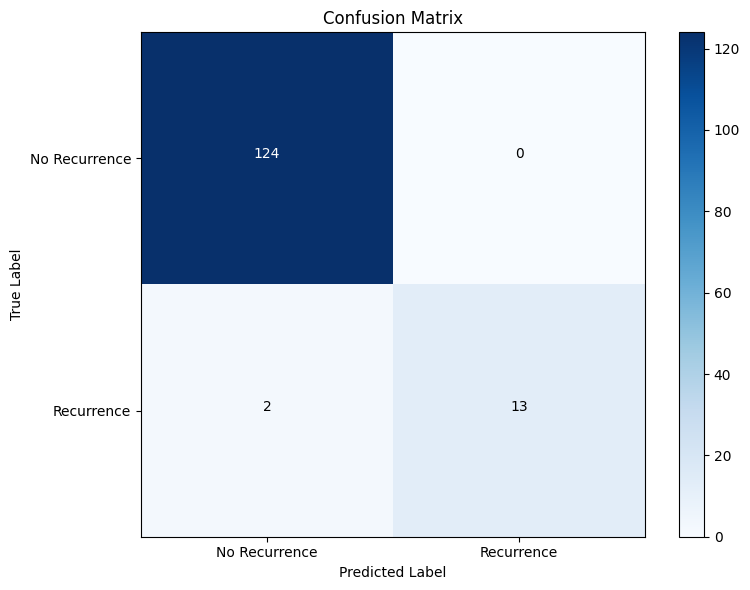

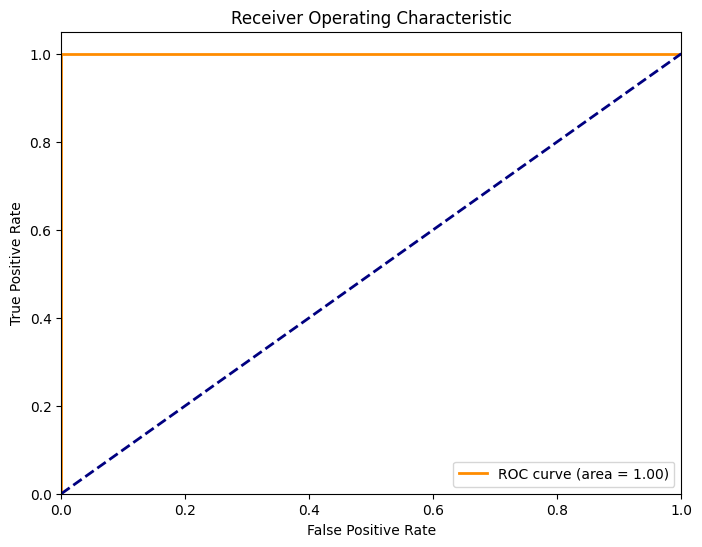

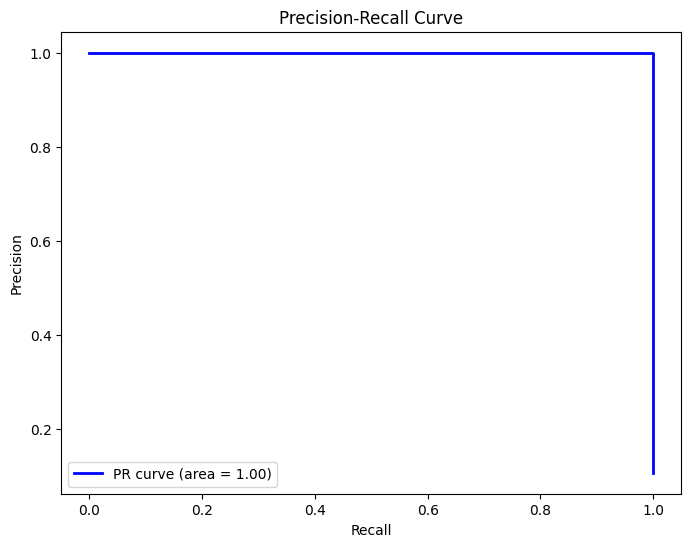

Final model performance:
Accuracy: 0.9856
AUC: 1.0000
F1 Score: 0.9852


In [24]:
# Evaluate the model
metrics = evaluate_binary_classifier(
    model=advanced_model,
    X_test=X_test_seq,
    y_test=y_test
)

print(f"Final model performance:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"AUC: {metrics['auc']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")